In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [64]:
img_path = '/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images/train_images'

In [65]:
from glob import glob

In [66]:
file_names = glob(img_path+'/*.jpg')

In [67]:
import cv2

In [68]:
img = cv2.imread(file_names[0])

In [69]:
import matplotlib.pyplot as plt

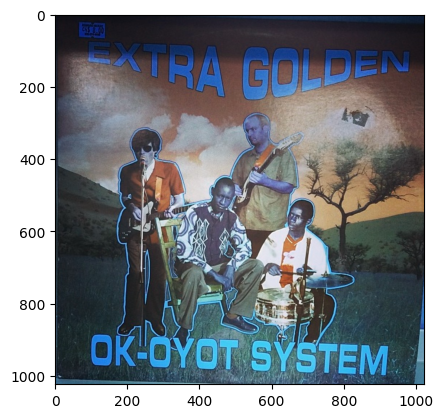

In [70]:
plt.imshow(img )

In [71]:
data = pd.read_csv("/kaggle/input/textocr-text-extraction-from-images-dataset/annot.csv")

In [72]:
data.head()

,Unnamed: 0,id,image_id,bbox,utf8_string,points,area
0,0,a4ea732cd3d5948a_1,a4ea732cd3d5948a,"[525.83, 3.4, 197.64, 33.94]",Performance,"[525.83, 3.4, 723.47, 7.29, 722.76, 36.99, 525...",6707.90
1,1,a4ea732cd3d5948a_2,a4ea732cd3d5948a,"[534.67, 64.68, 91.22, 38.19]",Sport,"[535.73, 64.68, 623.41, 67.51, 625.89, 102.87,...",3483.69
2,2,a4ea732cd3d5948a_3,a4ea732cd3d5948a,"[626.95, 63.62, 96.52, 31.82]",Watch,"[626.95, 63.62, 721.7, 63.62, 723.47, 95.44, 6...",3071.27
3,3,a4ea732cd3d5948a_4,a4ea732cd3d5948a,"[577.4, 141.87, 147.13, 43.1]",...period.,"[580.02, 143.61, 724.53, 141.87, 723.66, 184.9...",6341.30
4,4,a4ea732cd3d5948a_5,a4ea732cd3d5948a,"[391.03, 163.9, 60.82, 38.65]",.,"[395.2, 163.9, 451.85, 191.94, 445.59, 202.55,...",2350.69


In [73]:
data[data['image_id'] == file_names[0].split('/')[-1][:-4]]

,Unnamed: 0,id,image_id,bbox,utf8_string,points,area
674889,674889,f644219f560e3778_1,f644219f560e3778,"[64.54, 22.34, 75.25, 47.22]",.,"[67.49, 22.34, 139.79, 28.25, 139.79, 69.56, 6...",3553.30
674890,674890,f644219f560e3778_2,f644219f560e3778,"[68.97, 62.18, 419.03, 191.81]",EXTRA,"[77.82, 62.18, 488.0, 71.03, 483.57, 253.99, 6...",80374.14
674891,674891,f644219f560e3778_3,f644219f560e3778,"[510.13, 81.36, 486.9, 180.01]",GOLDEN,"[511.6, 81.36, 995.55, 82.84, 997.03, 242.19, ...",87646.87
674892,674892,f644219f560e3778_4,f644219f560e3778,"[89.63, 876.63, 432.3, 118.03]",OK-OYOT,"[91.1, 876.63, 521.93, 889.91, 521.93, 994.66,...",51024.37
674893,674893,f644219f560e3778_5,f644219f560e3778,"[532.26, 892.86, 402.8, 118.03]",SYSTEM,"[532.26, 892.86, 935.06, 910.56, 930.63, 1010....",47542.48


In [74]:
def convertTolist(string):
    return list(map(float , string[1:-1].split(',')))

In [75]:
data['bbox'] = data['bbox'].apply(convertTolist)

In [76]:
import shutil
from sklearn.model_selection import train_test_split

In [77]:
images = data['image_id'].unique()

In [78]:
labeled  = []
nonlabeled = []
for i in file_names:
    j = i.split('/')[-1][:-4]
    if j not in images:
        nonlabeled.append(i)
    else :
        labeled.append(i)

In [79]:
train , test = train_test_split(labeled , train_size=0.8 , random_state=42)
train , val = train_test_split(train , train_size=7/8 , random_state=42)

In [80]:
def make_yolo_format(name , data , labels_data):
    images_path = os.path.join("datasets" , "TextOCR" , name , "images")
    labels_path = os.path.join("datasets" , "TextOCR" , name , "labels")
    
    os.makedirs(images_path , exist_ok = True)
    os.makedirs(labels_path , exist_ok = True) 
    
    for i in data : 
        width , height , _  = cv2.imread(i).shape
        img_name , ext = i.split('/')[-1].split('.') 
        bbox = labels_data[labels_data['image_id']==i.split('/')[-1][:-4]]['bbox']

        label_p = labels_path + f'/{img_name}.txt'
        count = 0
        
        for box in bbox :
            xcen = (box[0] + (box[2]/2))/width
            ycen = (box[1] + (box[-1]/2))/height
            width = (box[2])/width
            height = (box[-1])/height 
            
            if count == 0 :
                with open(label_p , 'w') as file :
                    file.write(f'{count} {xcen:.4f} {ycen:.4f} {width:.4f} {height:.4f}\n')
            else : 
                with open(label_p , 'a') as file :
                    file.write(f'{count} {xcen:.4f} {ycen:.4f} {width:.4f} {height:.4f}\n')
            count += 1
        shutil.copy(i , images_path+f'/{img_name}.{ext}')

In [88]:
# directory_path = '/kaggle/working/yolov8n.pt'
# os.remove(directory_path)

In [89]:
make_yolo_format("train" , train[:1000] , data)
make_yolo_format("valid" , val[:1000] , data)
make_yolo_format("test" , test[:1000] , data)

In [90]:
data_yaml = f'''

path : TextOCR

train : train/images
val : valid/images
test : test/image

nc : 1 
names : ['Text']

'''

In [91]:
with open('data.yaml' , 'w') as file:
    file.write(data_yaml)

In [93]:
!pip install ultralytics
!pip install ipywidgets

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [94]:
from ultralytics import YOLO

In [95]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 70.6MB/s]


In [96]:
model.train(
    data = 'data.yaml',
    epochs = 3 ,
    batch = 2 , 
    device = 'cuda',
    imgsz = 320,
    cache = True
)

Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=3, time=None, patience=100, batch=2, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=Non

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/TextOCR/train/labels... 1000 images, 0 backgrounds, 980 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 655.55it/s]

train: WARNING ⚠️ /kaggle/working/datasets/TextOCR/train/images/000c91f4578d37a6.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      11367       30276      836.71      726.81]
train: WARNING ⚠️ /kaggle/working/datasets/TextOCR/train/images/002452a1969ae6a7.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     749.15      8517.2       515.6      867.48      1879.5      7798.4      618.72      883.93      336.33      9465.8      653.68      997.75      1903.2       11141      1126.3      1068.8       14608      7866.6      1101.9        1077       16911      8137.6      1116.6      1192.8]
train: WARNING ⚠️ /kaggle/working/datasets/TextOCR/train/images/00295fe2b9988a90.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     4747.7      5508.6      319.05      1266.8      1.4703      8682.7       12603      300.18      1166.3      1.6357      9354.3       13980       311.4      1226.5       1.153


train: Caching images (0.0GB RAM): 100%|██████████| 20/20 [00:00<00:00, 253.30it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/TextOCR/valid/labels... 1000 images, 0 backgrounds, 990 corrupt: 100%|██████████| 1000/1000 [00:01<00:00, 593.89it/s]


val: WARNING ⚠️ /kaggle/working/datasets/TextOCR/valid/images/001156eb13f37194.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2346       18154      4712.8      558.95       300.7      1.5165       37618      6170.8      1622.3      415.97       51470      6477.3      292.36      522.77      2.4339      1.0058        9795       20208      369.44      526.64      1.9644      1.0572      1636.7      4498.8      124.39      171.05
      5.4357      1.7754]
val: WARNING ⚠️ /kaggle/working/datasets/TextOCR/valid/images/0017fde4b397259a.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5489       29197       76246      4900.6      761.18      1.3159       65690       74043       11022      775.96]
val: WARNING ⚠️ /kaggle/working/datasets/TextOCR/valid/images/00247a79c7cb58a2.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     2905.4      803.15      692.31      1012.5      2488.4     

val: Caching images (0.0GB RAM): 100%|██████████| 10/10 [00:00<00:00, 124.23it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3     0.524G       4.29      4.994      2.918          4        320: 100%|██████████| 10/10 [00:01<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.81it/s]

                   all         10         10   0.000545        0.1   0.000314   3.14e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3     0.373G      4.282      4.781      2.858          6        320: 100%|██████████| 10/10 [00:00<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 19.26it/s]

                   all         10         10   0.000548        0.1   0.000347   3.47e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3     0.352G      4.385      4.914      3.336          2        320: 100%|██████████| 10/10 [00:00<00:00, 11.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 20.79it/s]

                   all         10         10   0.000535        0.1   0.000386   3.86e-05



3 epochs completed in 0.004 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.39it/s]


                   all         10         10   0.000534        0.1   0.000367   3.67e-05
Speed: 0.2ms preprocess, 25.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▁█▃
lr/pg1,▁█▃
lr/pg2,▁█▃
metrics/mAP50(B),▁▆█
metrics/mAP50-95(B),▁▁█
metrics/precision(B),▄█▁
metrics/recall(B),▁▁▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▂▁█


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7853969379d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [97]:
model.save('ocr_pre_detect.pt')

In [108]:
results = model.predict(train[0])


image 1/1 /kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images/train_images/837617f017d44ae6.jpg: 320x160 (no detections), 88.9ms
Speed: 1.0ms preprocess, 88.9ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 160)


In [109]:
test_img = cv2.imread(train[0])

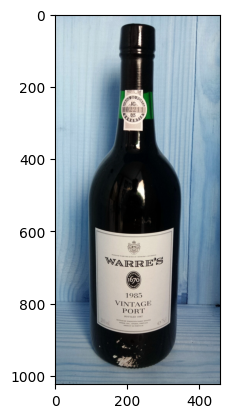

In [110]:
plt.imshow(test_img)

In [111]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Text'}
 obb: None
 orig_img: array([[[184, 203, 216],
         [185, 204, 217],
         [187, 208, 223],
         ...,
         [170, 196, 210],
         [160, 186, 200],
         [153, 180, 194]],
 
        [[186, 205, 218],
         [186, 205, 218],
         [187, 208, 223],
         ...,
         [168, 194, 208],
         [159, 185, 199],
         [155, 182, 196]],
 
        [[184, 206, 218],
         [184, 206, 218],
         [186, 208, 220],
         ...,
         [164, 189, 205],
         [160, 185, 201],
         [155, 182, 196]],
 
        ...,
 
        [[114, 137, 152],
         [113, 136, 151],
         [115, 138, 154],
         ...,
         [116, 137, 152],
         [114, 135, 150],
         [114, 136, 148]],
 
        [[111, 134, 149],
         [111, 134, 149],
         [115, 138, 153],
         ...,
         [121, 140, 

In [107]:
train[0]

'/kaggle/input/textocr-text-extraction-from-images-dataset/train_val_images/train_images/837617f017d44ae6.jpg'